In [78]:
import os
import glob
import LatLon 
import numpy as np
import pandas as pd

# plot
%matplotlib inline
import pylab
import seaborn as sns
sns.set_style("whitegrid")

# date
from dateutil import parser
from matplotlib.dates import date2num

# database
import dataset
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

# Load Data

  * Original decision was to store the data straight to disk as flat text files.
  * This lower the load on the pi, so lets grab the right columns, and build up a large ~200MB dataframe

In [112]:
filenamepattern = '/Users/ajmendez/flight/locations_*.log'
data = None
for filename in glob.glob(filenamepattern):
    tmp = pd.read_csv(filename, skiprows=1, usecols=[4,6,7,11,14,15], 
                     names='flight date time alt lat lon'.split())
    if data is None:
        data = tmp
        break
    else:
        data =  pd.concat([data, tmp])

# Create Tags

  * datenum -- the number of days since the start
  * distance -- distance away from detector
  * heading -- angle from north for plane

In [126]:
for i in data.index:
    if len(data['lon'][i].shape) > 0:
        print data['lon'][i]
    break

In [117]:
tmp = (data['date']+' '+data['time']).apply(parser.parse)
# data['datenum'] = date2num(tmp.apply(parser.parse))
# data['datenum'] -= data['datenum'].min()

In [143]:
ant = LatLon.LatLon(39.331832, -76.623450)
def get_heading_distance(tmp):
    heading, distance = np.zeros( (2, tmp.shape[0]) )
    for i in tmp.index:
        try:
            loc = LatLon.LatLon(tmp['lat'][i],tmp['lon'][i])
        except Exception as e:
            print i, tmp['lat'][i],tmp['lon'][i]
            raise
        heading[i] = ant.heading_initial(loc)
        distance[i] = ant.distance(loc)
    return np.deg2rad(heading), distance

data['heading'], data['distance'] = get_heading_distance(data[['lat', 'lon']])

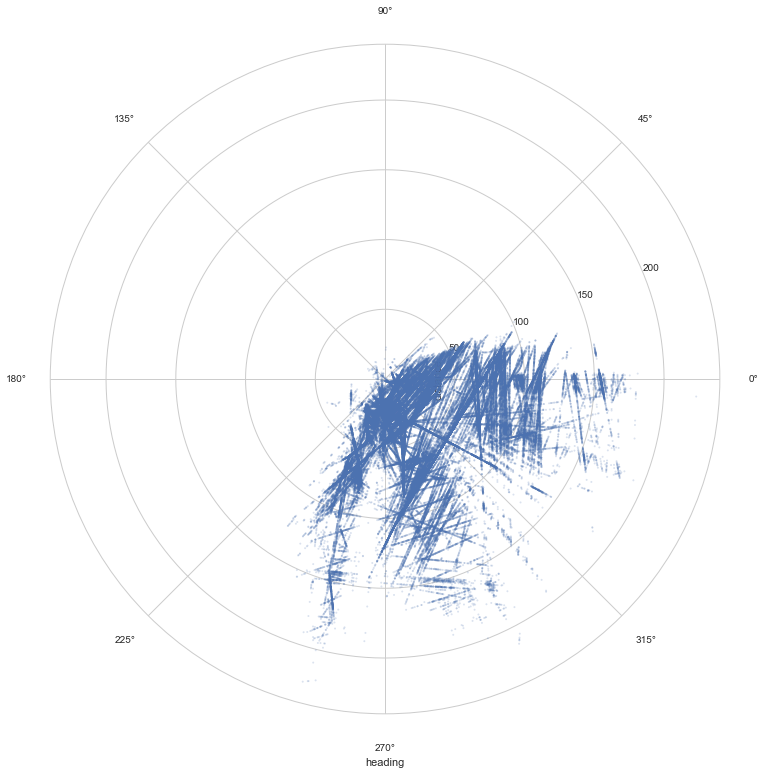

In [148]:
pylab.figure(figsize=(12,12))
ax = pylab.subplot(111, projection='polar')
data[data['distance'] < 1000].plot('heading', 'distance', 'scatter', ax=ax, 
                                   s=4, edgecolor='none', alpha=0.2)
# setup(subplt=(1,2,2))

# Clean Data

  * There are a bunch of very odd records, so clean by removing anything far far away.
  * Some of these are due to being able to "observe" planes close to the airport so that their GPS signal is quite bad.
  * 

# Save Data

In [ ]:
# save it as a db for other things.
# db = dataset.connect('sqlite:///Users/ajmendez/flight.db')
engine = create_engine('sqlite:////Users/ajmendez/flight.db')
if not database_exists(engine.url):
    create_database(engine.url)

with engine.connect() as conn, conn.begin():
    data.to_sql('data', engine)
